In [17]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as net
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

In [12]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [11]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [10]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

## 1. Experiments with covariates in the DGP

$y_i = \tau*T_i+\beta'*x_i+e_i$

In [22]:
tau = 4
corr = .5
conf=False
p = 5
p0 = 5 # number of covariates used in the DGP
Nrange = range(10,100,2)
N=500
flagX=1
Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 45/45 [00:00<00:00, 3761.18it/s]


## DAG

{'Treatment': {'Outcome': {}}, 'Outcome': {}, 'Covariates': {'Outcome': {}}}


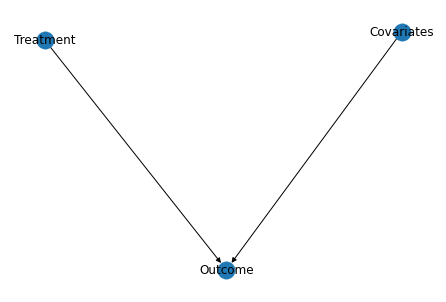

In [20]:
G = net.DiGraph()
G.add_edge('Treatment','Outcome')
G.add_edge('Covariates','Outcome')
print(G.adj)
net.draw(G,with_labels=True)
plt.show()

In [30]:
data = np.concatenate([Y,T,X],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'X1', 'X2','X3','X4','X5']
data.to_csv('DGP_Covariate.csv')

# real-life situation

outcome: income.  
covariates: education, age, sex, race. 
treatment: economic trends in one specific year (good or bad). 
The covariates will effect the outcome, the treatment will also impact the outcome, but the treatment whether the economic treads in one specific year is good or bad shall not impact the covariates.

 # do not control any covariates

In [25]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:06<00:00, 296.59it/s]


In [27]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.05172721970728832, RMSE=4.414251813117436, size=0.0485
N=1000: bias=0.02408071822435952, RMSE=1.391372431188011, size=0.0495


# control for all the covariates

In [28]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:09<00:00, 215.48it/s]


In [29]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.001604793346993982, RMSE=0.14471569111510574, size=0.057
N=1000: bias=0.00024488332481686383, RMSE=0.04282144695366161, size=0.0385


# 2. Simulate a DGP with a confounder (common cause)

In [32]:
def fn_generate_data_conf(tau,N,p,corr):

    nvar = p+1 
    corr = 0.5 # correlation for multivariate normal
    X = fn_generate_multnorm(N,corr,nvar)
    C = X[:,1].reshape([N,1]) # confounder
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    Yab = tau*T+0.5*C+err
    Tab = T+0.5*C

    return (Yab,Tab,C)

In [33]:
tau = 4
corr = .5
p = 3
Y,T,C = fn_generate_data_conf(tau,N,p,corr)

In [34]:
data = np.concatenate([Y,T,C],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'Confounder']
data.to_csv('DGP_confounder.csv')

# DAG

{'Treatment': {'Outcome': {}}, 'Outcome': {}, 'Confounder': {'Outcome': {}, 'Treatment': {}}}


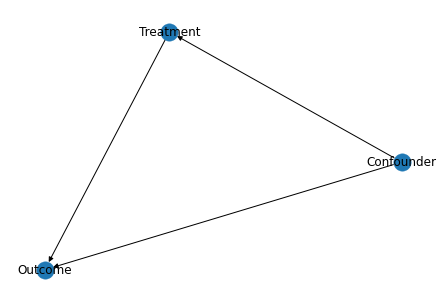

In [35]:
G = net.DiGraph()
G.add_edge('Treatment','Outcome')
G.add_edge('Confounder','Outcome')
G.add_edge('Confounder','Treatment')
print(G.adj)
net.draw(G,with_labels=True)
plt.show()

# real-life situation

Outcome: income. 
treatment: education. 
confounder: the highest education levels of parents. 
The highest education level of parents shall influence the income and education level of their children. Children's education level will influence their own income level.

# do not control the confounder

In [36]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:08<00:00, 248.51it/s]


In [37]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.9674283949787077, RMSE=1.0129629022505993, size=0.974
N=1000: bias=-0.9722271364795465, RMSE=1.0071939121635098, size=0.9985


# do control the confounder

In [38]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:08<00:00, 234.86it/s]


In [39]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.00030308786557106047, RMSE=0.14337086000561383, size=0.059
N=1000: bias=0.0012112429004477062, RMSE=0.04552596834049464, size=0.0525


# 3. Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

In [40]:
def fn_generate_data_s(tau,N,p,corr):

    nvar = p+1 # 1 for selection bias
    corr = 0.5 # correlation for multivariate normal
 
    allX = fn_generate_multnorm(N,corr,nvar)
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Y = tau*T+err
    S = 0.5*T+0.5*Y+U

    return (Y,T,S)

In [41]:
tau = 4
corr = 0.5
p = 3
N = 1000
Y,T,S = fn_generate_data_s(tau,N,p,corr)

In [42]:
data = np.concatenate([Y,T,S],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'S']
data.to_csv('DGP_selection_bias.csv')

# DAG

{'Treatment': {'Outcome': {}, 'Selection Bias': {}}, 'Outcome': {'Selection Bias': {}}, 'Selection Bias': {}}


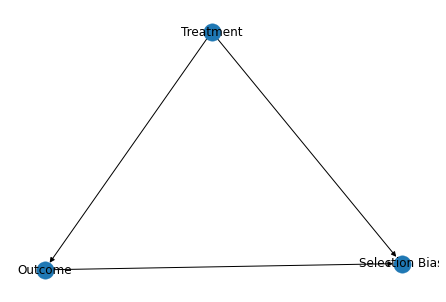

In [46]:
G = net.DiGraph()
G.add_edge('Treatment','Outcome')
G.add_edge('Treatment','Selection Bias')
G.add_edge('Outcome','Selection Bias')
print(G.adj)
net.draw(G,with_labels=True)
plt.show()

# real-life situation

People who had job training class shall have more chance to get a higher level of income. People who choose to have job training class by themselves may be more motivated to earn a high level of income. People who have higher level of income may be more eager to pay money and have job training classes.

# control for the variable in between the path from cause to effect

In [47]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)
        covars = np.concatenate([T,Z],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:08<00:00, 233.09it/s]


In [48]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-1.1891769203659996, RMSE=1.2195602085800221, size=0.9905
N=1000: bias=-1.2037230275250963, RMSE=1.2066751844760013, size=1.0


# do not control for the variable in between the path from cause to effect

In [49]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:06<00:00, 303.59it/s]


In [50]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0022526689287880415, RMSE=0.19924257597431058, size=0.0535
N=1000: bias=-0.0019258322139875169, RMSE=0.06333231143869053, size=0.0465
